# Feature Impact Analysis and Visualization

## Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    HAS_SNS = True
except ImportError:
    HAS_SNS = False


# Load .npz
NPZ_PATH = "processed_dataset.npz"

data = np.load(NPZ_PATH, allow_pickle=True)

X = data["X"]
y = data["y"]

if "feature_names" in data.files:
    feature_names = data["feature_names"]
    feature_names = [fn.decode("utf-8") if isinstance(fn, (bytes, np.bytes_)) else str(fn) for fn in feature_names]
else:
    feature_names = [f"f_{i}" for i in range(X.shape[1])]

df = pd.DataFrame(X, columns=feature_names)
df["y"] = y.astype(int)

print("Loaded:", df.shape)
print("X shape:", X.shape, "y shape:", y.shape)

Loaded: (21374, 52)
X shape: (21374, 51) y shape: (21374,)


## Feature–Outcome Correlation Analysis

Compute the **Pearson correlation** between each feature and the binary outcome `y`
(`y=1` home win, `y=0` not win) to measure how strongly each feature is linearly associated
with match results.

- **Positive corr** → larger feature values indicate higher home-win probability  
- **Negative corr** → larger feature values indicate lower home-win probability  

Categorize features by correlation magnitude:
- **Strong**: \|corr\| ≥ 0.20  
- **Weak**: \|corr\| ≤ 0.05  

**Findings:** L1 ability-difference features and L3 Elo/form features show the strongest
correlations, and betting odds (B365) are highly informative. Most L2 tactical-style
features have weak individual correlation, suggesting limited direct linear impact.
Overall correlations stay below ~0.35, reflecting the inherent noise in football outcomes.


=== Strongly correlated with win/loss (|corr| >= 0.20) ===
L1_diff_overall                   0.332781
B365A                             0.318514
L3_elo_diff                       0.318062
L1_diff_attack                    0.304028
B365H                            -0.283006
L1_attack_home_vs_defense_away    0.249924
L3_home_elo                       0.243713
L3_away_elo                      -0.209642
dtype: float64

=== Weakly correlated with win/loss (|corr| <= 0.05) ===
L2_away_buildUpPlayPassing        0.045393
L2_diff_chanceCreationShooting    0.040378
L2_home_chanceCreationShooting    0.039150
L1_home_gk_index                  0.037726
L2_away_defenceAggression        -0.036064
L2_home_defenceAggression         0.030699
L2_home_buildUpPlaySpeed         -0.024631
L2_diff_buildUpPlaySpeed         -0.020718
L2_diff_chanceCreationPassing     0.020058
L2_home_chanceCreationPassing     0.014374
L2_away_chanceCreationShooting   -0.013018
L2_away_chanceCreationPassing    -0.012425
L3_home

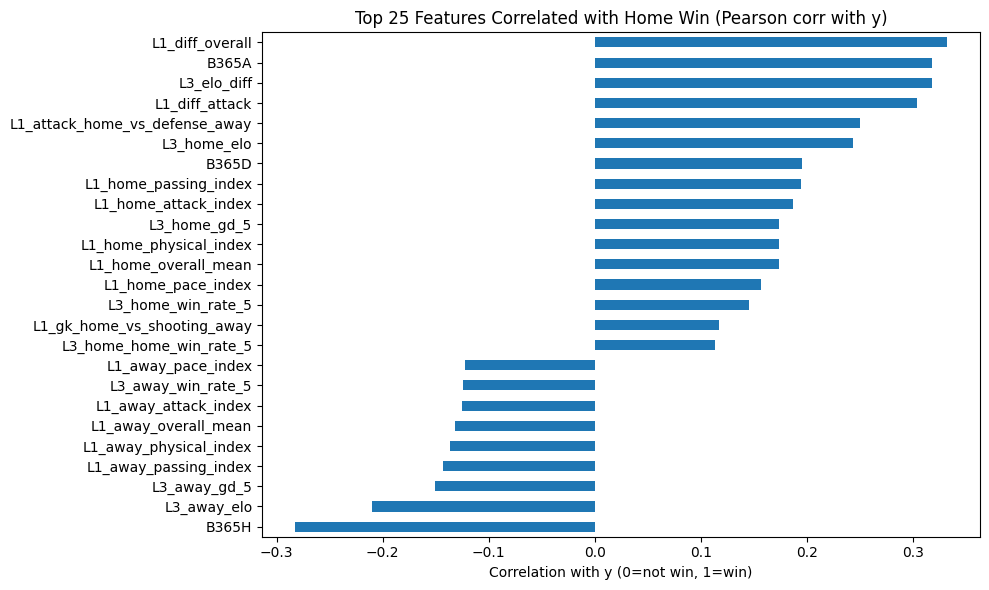

In [4]:
# Correlation(feature, y) ranking + plot
corr_to_y = df.drop(columns=["y"]).corrwith(df["y"]).sort_values(key=lambda s: s.abs(), ascending=False)

STRONG_TH = 0.20   # abs(corr) >= 0.20
WEAK_TH   = 0.05   # abs(corr) <= 0.05

strong_feats = corr_to_y[ corr_to_y.abs() >= STRONG_TH ]
weak_feats   = corr_to_y[ corr_to_y.abs() <= WEAK_TH ]

print("\n=== Strongly correlated with win/loss (|corr| >= %.2f) ===" % STRONG_TH)
print(strong_feats)

print("\n=== Weakly correlated with win/loss (|corr| <= %.2f) ===" % WEAK_TH)
print(weak_feats)


TOPK = 25
top_corr = corr_to_y.head(TOPK)

plt.figure(figsize=(10, 6))
top_corr.sort_values().plot(kind="barh")
plt.title(f"Top {TOPK} Features Correlated with Home Win (Pearson corr with y)")
plt.xlabel("Correlation with y (0=not win, 1=win)")
plt.tight_layout()
plt.show()

## Distribution Analysis of Strongly Correlated Features

To further understand how the most predictive features separate match outcomes,
we visualize their distributions using boxplots grouped by match result (`y`).

Each plot compares:

- `y = 0` → Home team did not win  
- `y = 1` → Home team won  

These visualizations help us examine:

- Differences in **median values**
- Distribution shifts between classes
- Degree of **overlap** (which reflects task difficulty)
- Presence of outliers and variance structure

### Observations

- Strong features such as **L1_diff_overall**, **L1_diff_attack**, and **L3_elo_diff**
  show clear distribution shifts between winning and non-winning matches.
- Interaction features (e.g., attack vs. defense matching) also demonstrate
  meaningful separation.
- Betting odds exhibit strong class separation, confirming their predictive strength.
- Despite noticeable median differences, distributions still overlap significantly,
  indicating inherent uncertainty and randomness in football outcomes.

Overall, these boxplots visually confirm the correlation results and demonstrate
that match outcome prediction requires combining multiple features rather than
relying on a single variable.

<Figure size 600x400 with 0 Axes>

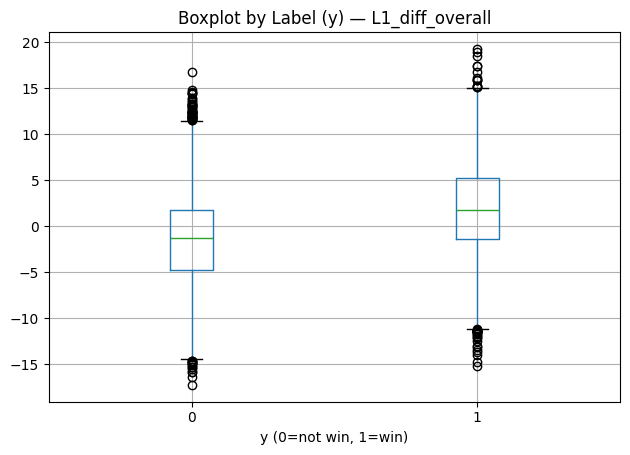

<Figure size 600x400 with 0 Axes>

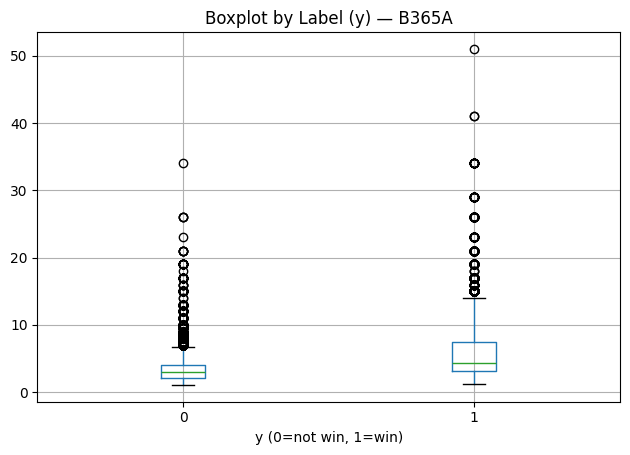

<Figure size 600x400 with 0 Axes>

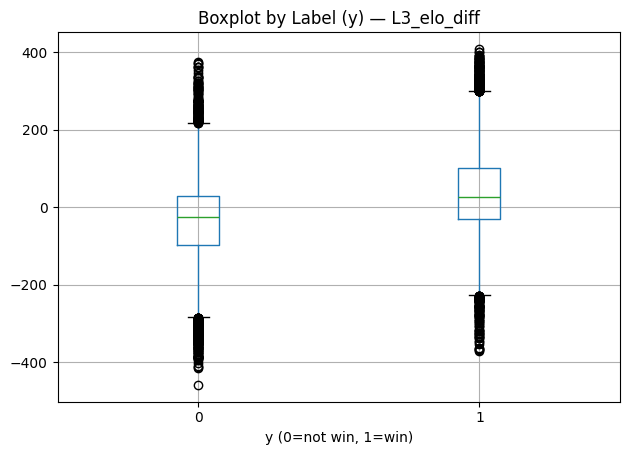

<Figure size 600x400 with 0 Axes>

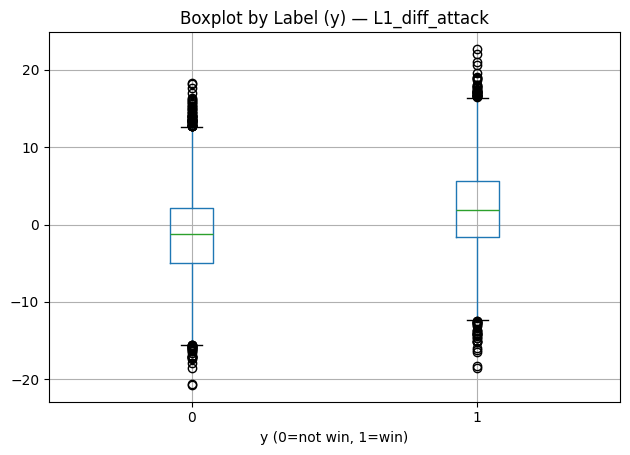

<Figure size 600x400 with 0 Axes>

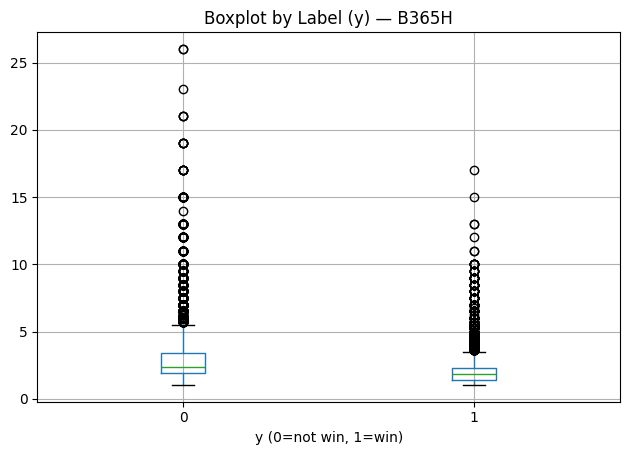

<Figure size 600x400 with 0 Axes>

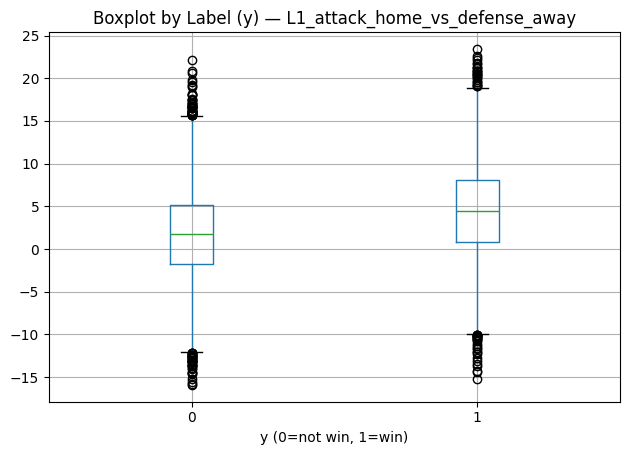

In [ ]:
# Distribution difference for top strong features
k = min(6, len(strong_feats))
top_strong_names = list(strong_feats.head(k).index)

if k == 0:
    print("\nNo features pass the strong threshold. Try lowering STRONG_TH.")
else:
    for col in top_strong_names:
        plt.figure(figsize=(6, 4))
        if HAS_SNS:
            sns.violinplot(data=df, x="y", y=col, inner="quartile")
            plt.title(f"Distribution by Label (y) — {col}")
        else:
            df.boxplot(column=col, by="y")
            plt.title(f"Boxplot by Label (y) — {col}")
            plt.suptitle("")
        plt.xlabel("y (0=not win, 1=win)")
        plt.tight_layout()
        plt.show()

## Feature–Feature Correlation Analysis
Compute and visualize the pairwise Pearson correlation matrix for a subset of top features. To examine relationships between the most influential variables, 

This heatmap helps us:

- Identify **multicollinearity**
- Detect **redundant variables**
- Understand structural relationships between feature groups (L1, L3, Odds)

### Observations

- Strong positive correlations appear among **L1 home ability features**
  (overall, attack, passing, physical, pace), indicating overlapping information.
- Elo-related features are also moderately correlated with ability-difference features,
  reflecting that team strength and rating systems are naturally aligned.
- Betting odds show strong correlation with strength-related features,
  suggesting that the market internalizes similar information.
- Negative correlations (e.g., between home and away strength indicators)
  reflect expected competitive balance dynamics.

Overall, the heatmap reveals structured clusters of related variables,
highlighting potential redundancy and motivating regularization or
feature selection in the modeling stage.

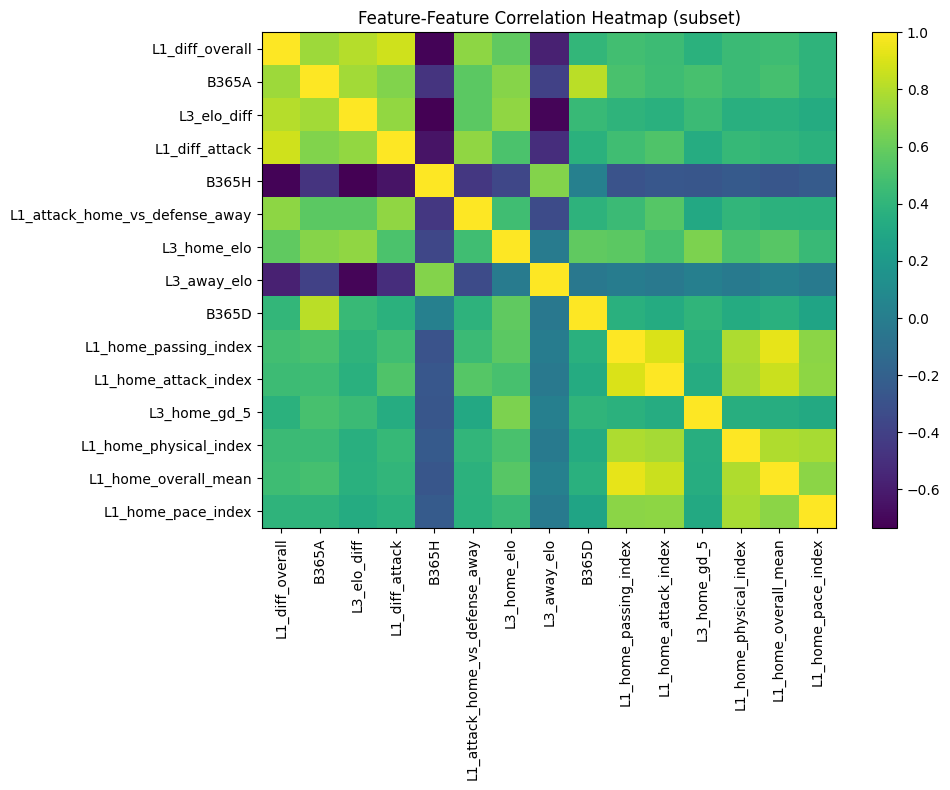

In [6]:
# Feature-feature correlation heatmap
subset_names = list(top_corr.head(15).index) 
corr_mat = df[subset_names].corr()

plt.figure(figsize=(10, 8))
if HAS_SNS:
    sns.heatmap(corr_mat, annot=False, cmap="coolwarm", center=0)
    plt.title("Feature-Feature Correlation Heatmap (subset)")
else:
    plt.imshow(corr_mat, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(subset_names)), subset_names, rotation=90)
    plt.yticks(range(len(subset_names)), subset_names)
    plt.title("Feature-Feature Correlation Heatmap (subset)")
plt.tight_layout()
plt.show()

## Overall Conclusions

From the correlation ranking, distribution plots, and feature–feature heatmap,
we can draw several key conclusions:

1. **Team strength difference is the strongest predictor.**  
   L1 ability-difference features (e.g., overall and attack differences) show
   the highest correlation with match outcome. This confirms that relative team
   strength plays a central role in determining home wins.

2. **Recent form (Elo and rolling statistics) adds significant predictive value.**  
   L3 dynamic features demonstrate strong association with outcomes,
   indicating that short-term performance trends matter beyond static ability.

3. **Betting odds are highly informative.**  
   B365 features rank among the strongest predictors, suggesting that
   the betting market effectively aggregates hidden information.

4. **Tactical style features (L2) have weak individual linear impact.**  
   Most L2 variables show low marginal correlation, implying that
   tactical preferences alone are not strong standalone predictors.

5. **Substantial overlap remains between classes.**  
   Even the strongest features do not fully separate wins from non-wins,
   reflecting the inherent randomness and uncertainty of football matches.

6. **Feature redundancy exists.**  
   Strong correlations among L1 features indicate multicollinearity,
   motivating regularization or dimensionality reduction in modeling.

Overall, match outcomes are influenced primarily by strength differences,
recent form, and market expectations, while tactical variables contribute
less directly in a linear sense.